In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split


## Helper functions!

In [52]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [53]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

### Baseline Model for comparison

No change made to the data at all... no variables added or removed and no scaling applied

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42     # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train))
model.summary()

Test MSE:  6.202418293994368
Train MSE:  6.2675254081872716


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.934e+05
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:16:41   Log-Likelihood:                -41125.
No. Observations:               17600   AIC:                         8.226e+04
Df Residuals:                   17593   BIC:                         8.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4437      0.124     84.158      0.000      10.200      10.687
Shops          0.1079      0.001     97.890      0.000       0.106       0.110
ATMs          -1.0121      0.011    -96.011      0.000      -1.033      -0.991
Downtown     -35.9429      0.995    -36.113      0.000     -37.894     -33.992
Weekday       -3.5078      0.042    -83.871      0.000      -3.590      -3.426
Center         7.3074      0.063    116.366      0.000       7.184       7.431
High           0.9774      0.041     23.777      0.000       0.897       1.058
==============================================================================
Omnibus:                    13943.449   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353715.237
Skew:                           3.690   Prob(JB):                         0.00
Kurtosis:                      23.685   Cond. No.                     4.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Preprocess the data for best model subset selection...

In [55]:
# Preprocess the data
# 1. Separate the data into training and test data
# 2. Fit the scaling to the training data and apply to both the train and test data 

# TO DO: Define columns to scale
columns_to_scale = ['ATMs', 'Shops',]

# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1     # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

# 2. Scale
scaler = StandardScaler().fit(train[columns_to_scale]) 

train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 

train.head()


,Withdraw,Shops,ATMs,Downtown,Weekday,Center,High
7214,71.451101,0.627193,0.830934,1,1,1,1
13522,64.949936,0.534761,0.286455,1,1,0,0
18479,70.265111,0.639356,0.014215,1,1,0,1
3366,70.693183,0.656382,0.558694,1,1,0,1
21645,16.757929,-1.508474,-1.346982,0,1,0,0


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [56]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 64 iterations and 1.40 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=82243.96 with 7 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High

BIC=82298.39 with 7 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High

test MSE: 6.22 has 7 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High


<Axes: >

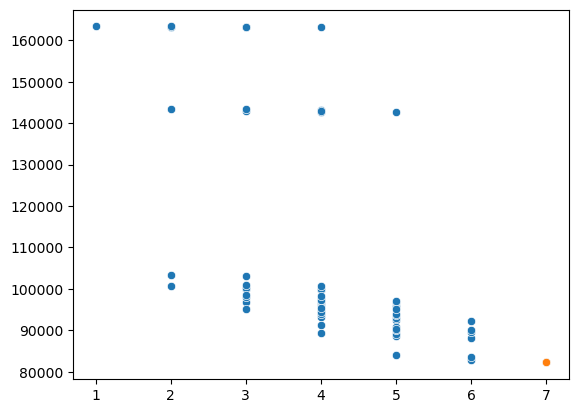

In [57]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

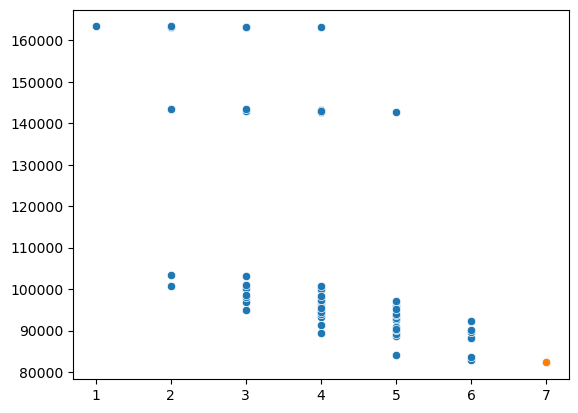

In [58]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

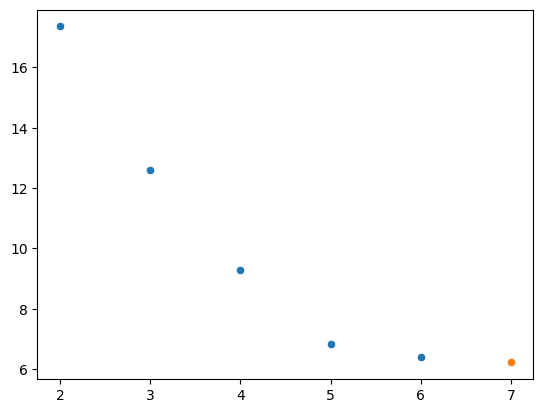

In [59]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []